# 2. Mājasdarbs. Oļegs Korsaks 051RDB146
• Atrast datu kopu internetā. Piemēram no Awesomedata vai UCI Machine Learning

Repository vai citur

– Vēlams ar simtiem līdz tūkstošiem ierakstiem,

– Vēlams desmitiem atribūtiem,

– Skaitliskās vērtības atribūtos,

– Ar mērķa klasi/klasēm, bet var arī nepārtraukta vērtība,

– Dažām datu kopām var nebūt izvirzīta mērķa klase. Šādos gadījumos var izmantot vienu no atribūtiem par mērķa klasi (ja ir iespējams loģiski pamatot).

• Sadalīt datu kopu apmācības un testa kopās.

• Izveidot daudzslāņu mākslīgo neironu tīklu ar tensorflow un veikt apmācību.

• Aprēķināt un novērtēt apmācības un testa kopas kļūdu.

• Pamainīt tīkla konfigurāciju un novērtēt izmaiņu ietekmi

– Arhitektūru – slēpto slāņu skaits, neironu skaits slāņos,

– Aktivācijas funkcijas,

– Optimizācijas metodi.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)

        # config = tf.compat.v1.ConfigProto()
        # config.gpu_options.per_process_gpu_memory_fraction = 0.2
        # config.gpu_options.allow_growth = True
        # session = tf.compat.v1.InteractiveSession(config=config)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=2600)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

sns.set_context('notebook', font_scale=2.0)
sns.set_style('darkgrid')

from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

2021-12-17 00:47:40.737844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 00:47:40.774403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 00:47:40.774821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2021-12-17 00:47:40.787445: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-17 00:47:40.787908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 00:47:40.788231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 00:47:40.788534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Datu ielāde

In [2]:
data = pd.read_csv('data/winequality-white.csv', sep=';')

### Datu analīze

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


## Datu vizualizācija un analīze

Paskatīsimies, vai ir dati, kuru vērtības ļoti atšķiras no vairuma.

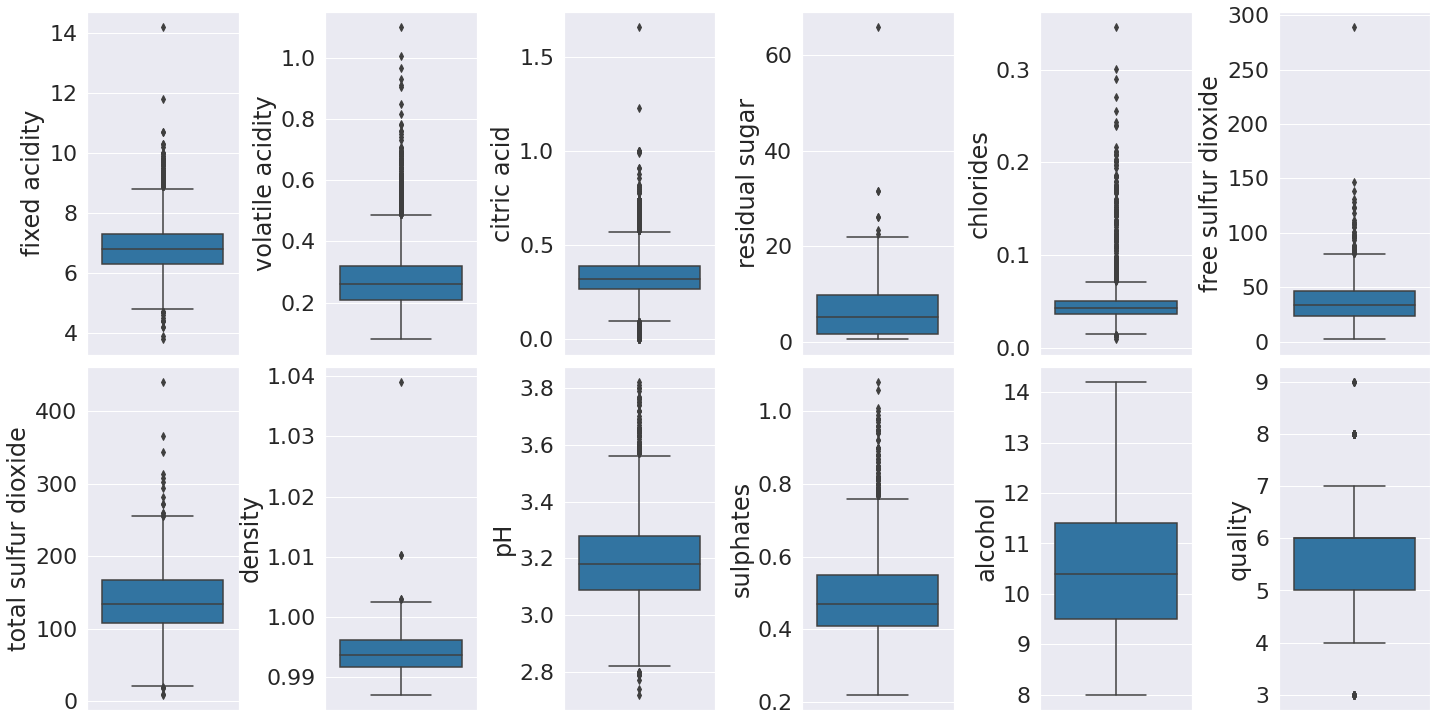

In [6]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.boxplot(y=col, data=data, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

Dažiem (piem. "total sulfur dioxide") ir tādas vērtības. Varbūt tie ietekmēs precizitāti.

Paskatīsimies uz vērtību sadali.

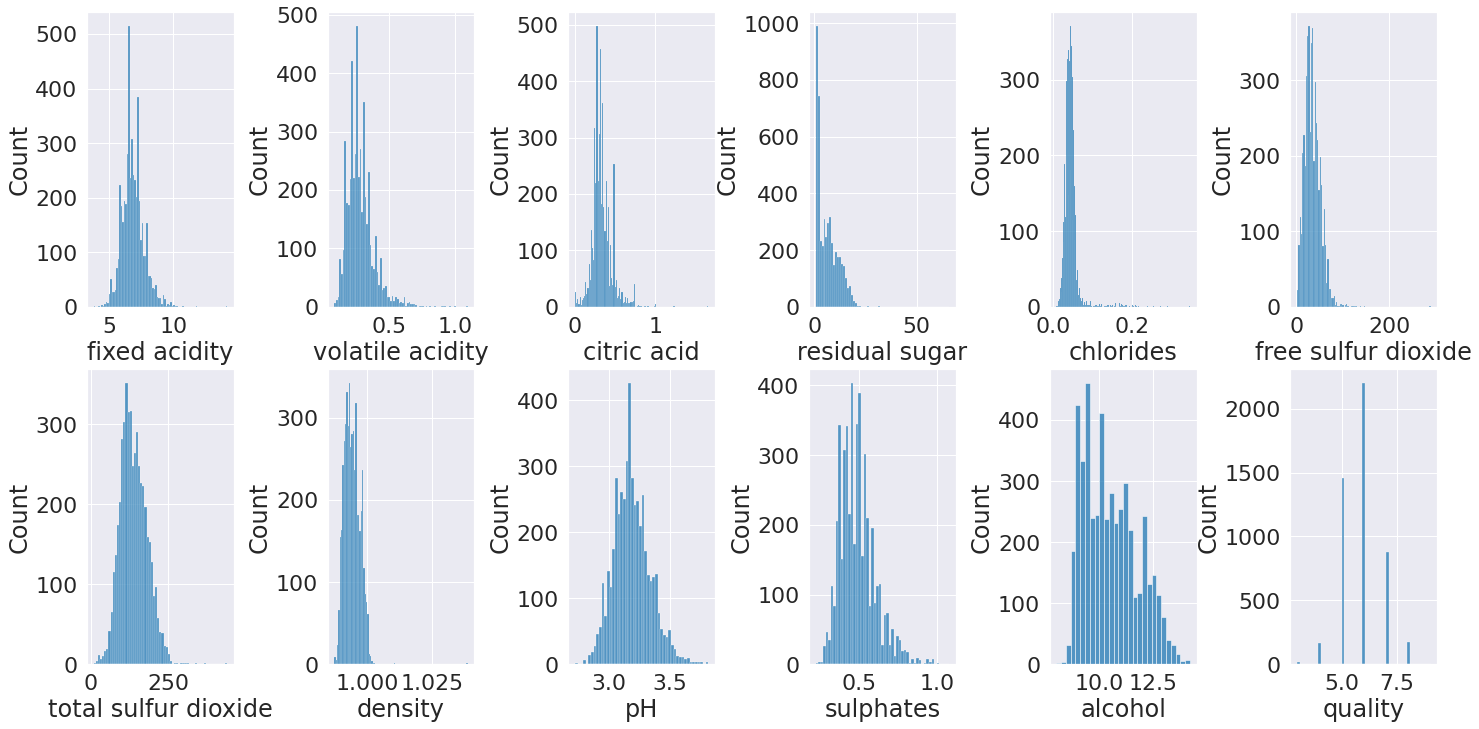

In [7]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.histplot(value, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

<AxesSubplot:xlabel='quality', ylabel='count'>

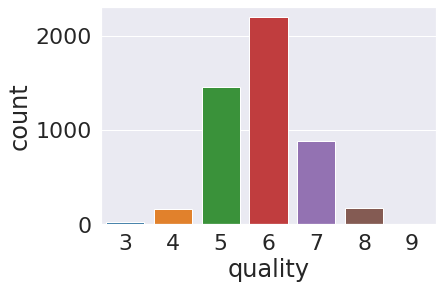

In [8]:
sns.countplot(x=data['quality'])

Bet "quality" gan ir cita lieta - mums pārsvārā ir vērtības 5,6 un pat nav dažu vērtību vispār. Tāda klašu nelīdzsvarotība nozīmē, ka modelis varēs labi noklasificēt tikai 5. un 6. kvalitātes gadījumus. Tātad datus būs janobalansē.

### Paramtetru korelācija

<AxesSubplot:>

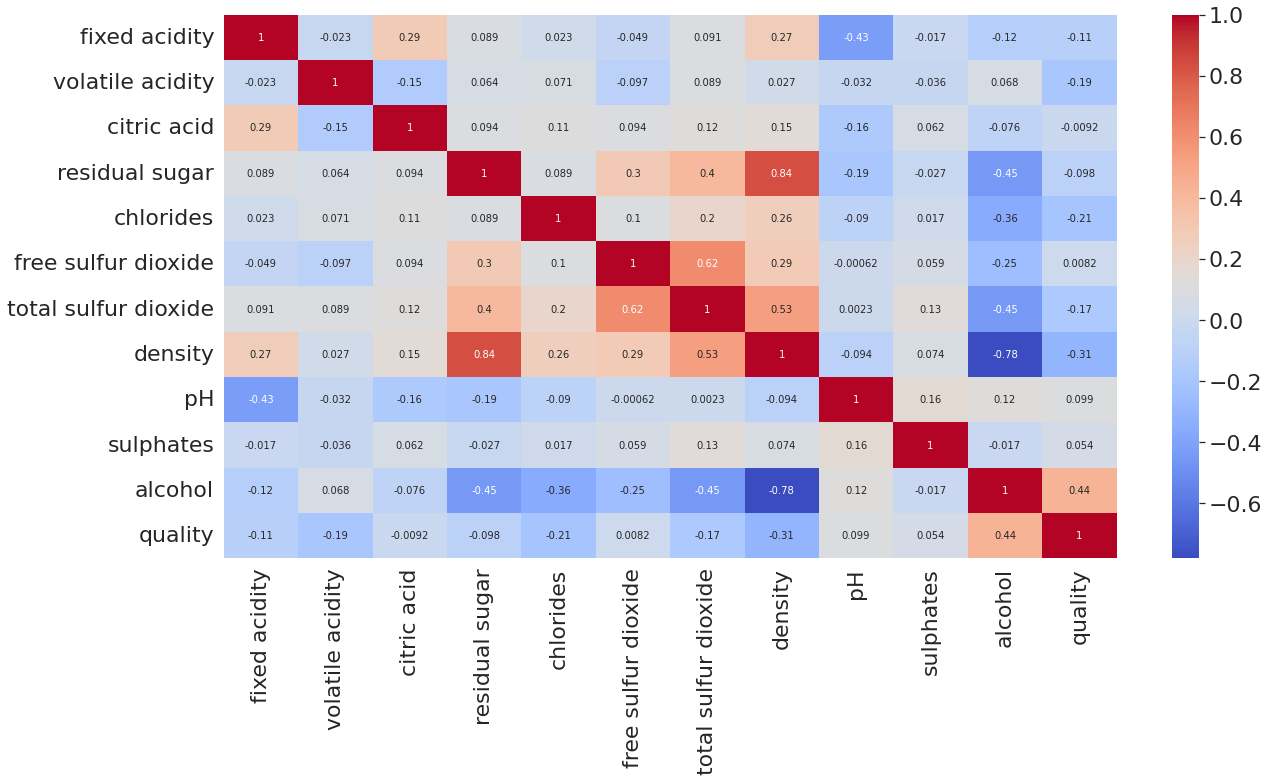

In [9]:
corr = data.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

Te ir redzams, ka "alcohol" ietekmē kvalitāti visvairāk, tātad tas ir svārīgs parametrs. Vēl alkohols korelē ar blīvumu (density), tas nozīmē, ka varam atstāt tikai vienu. Tas pats attiecas uz "free"/"total" sulfur dioxide, un dažu veidu skābumi (acidity). Ja būs problēmas ar precizitāti - varbūt noņemšu tos.

## Datu sadalīšana apmācības un pārbaudes kopās

In [10]:
samples = data.copy()
# samples.pop('free sulfur dioxide')
# samples.pop('citric acid')
qualities = samples.pop('quality')

### Klašu vērtību balansēšana

In [11]:
qualities.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [12]:
oversample = SMOTE(k_neighbors=4)
samples, qualities = oversample.fit_resample(samples, qualities)

In [13]:
qualities.value_counts()

6    2198
5    2198
7    2198
8    2198
4    2198
3    2198
9    2198
Name: quality, dtype: int64

Dati tika sabalansēti.

Izveidosim modeli ar vienu slēpto slāni ar input_count neironiem un izejas slāni ar vienu neironu.

In [14]:
def build_model(input_count: int, normalizer):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential([
        normalizer,
        tf.keras.layers.Dense(input_count, kernel_initializer=init, activation='relu', input_shape=(input_count,)),
        tf.keras.layers.Dense(1)
    ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [15]:
attr_count = len(samples.keys())
print(attr_count, len(qualities.value_counts()))

11 7


Mums ir 11 atribūti un 7 klases, jo nav datu priekš citām klasēm.
Tagad uzbūvēsim modeli un trenēsim to:

In [16]:
def plot_history(history):
    plt.figure(figsize=(18, 10))
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model_mse')
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [17]:
def evaluate_model(model, samples, qualities, epochs=100):
    samples_train, samples_test, qualities_train, qualities_test = train_test_split(samples, qualities, test_size=0.3,
                                                                                    random_state=0)
    history = model.fit(samples_train, qualities_train, validation_data=(samples_test, qualities_test), shuffle=False,
                        epochs=epochs, verbose=0)
    plot_history(history)
    result = model.predict(samples_test)

    for sample_idx in (-5, -10, -20):
        print(f'Predicted: {result[sample_idx][0]}, Expected: {qualities_test.iat[sample_idx]}')

In [ ]:
samples = tf.convert_to_tensor(samples)

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(samples)

In [ ]:
model = build_model(attr_count, normalizer)
evaluate_model(model, samples, qualities, epochs=100)

Nav tik labi rezultāti. Pievienosim vēl divus tik pat lielus slāņus.

In [ ]:
def build_model(input_count: int, normalizer):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential([
        normalizer,
        tf.keras.layers.Dense(input_count, kernel_initializer=init, activation='relu', input_shape=(input_count,)),
        tf.keras.layers.Dense(input_count, activation='relu'),
        tf.keras.layers.Dense(input_count, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, normalizer)
evaluate_model(model, samples, qualities, epochs=100)

Pamainīsim neironu skaitu slāņos.

In [ ]:
def build_model(input_count: int, normalizer):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential([
        normalizer,
        tf.keras.layers.Dense(32, kernel_initializer=init, activation='relu', input_shape=(input_count,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, normalizer)
evaluate_model(model, samples, qualities, epochs=100)

Pamēģināšu to pašu modeli bet ar vairākām epohām, 1000.

In [ ]:
model = build_model(attr_count, normalizer)
evaluate_model(model, samples, qualities, epochs=1000)

Palielināšu learning rate x10.

In [ ]:
def build_model(input_count: int, normalizer):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential([
        normalizer,
        tf.keras.layers.Dense(32, kernel_initializer=init, activation='relu', input_shape=(input_count,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.005)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, normalizer)
evaluate_model(model, samples, qualities, epochs=1000)

Tagad kļūda raustas. Samazināšu learning rate x2. un Palielināšu epohu skaitu x2.

In [ ]:
def build_model(input_count: int, normalizer):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential([
        normalizer,
        tf.keras.layers.Dense(32, kernel_initializer=init, activation='relu', input_shape=(input_count,)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.00025)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, normalizer)
evaluate_model(model, samples, qualities, epochs=2000)

Izmēģināšu mean absolute erorr loss-funkciju.

In [ ]:
def build_model(input_count: int, output_count: int):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, kernel_initializer=init, activation='relu', input_shape=(input_count,)))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate=0.0025)

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, 1)
evaluate_model(model, samples, qualities, epochs=2000)

Palika sliktāk. Pamēģināšu Nadam optimizācijas algoritmu.

In [ ]:
def build_model(input_count: int, output_count: int):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, kernel_initializer=init, activation='relu', input_shape=(input_count,)))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    adam = tf.keras.optimizers.Nadam(learning_rate=0.0025)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, 1)
evaluate_model(model, samples, qualities, epochs=2000)

Nu ļoti slikts rezultāts :/

Pamēģināšu palielināt slāņu, neironu un epohu skaitu.

In [ ]:
def build_model(input_count: int, output_count: int):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, kernel_initializer=init, activation='relu', input_shape=(input_count,)))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, 1)
evaluate_model(model, samples, qualities, epochs=10000)

Varbūt aktivācijas funkcija ir pie vainas (neticu, bet jāparbauda). Pamainīšu uz sigmoid.

In [ ]:
def build_model(input_count: int, output_count: int):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, kernel_initializer=init, activation='sigmoid', input_shape=(input_count,)))
    model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(8, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))

    adam = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, 1)
evaluate_model(model, samples, qualities, epochs=10000)

Bet ja es pamainīšu pēdēja neirona aktivācijas funkciju uz relu? Jo pirms tam tam bija lineāra funkcija.

In [ ]:
def build_model(input_count: int, output_count: int):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, kernel_initializer=init, activation='relu', input_shape=(input_count,)))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))

    adam = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mse', optimizer=adam, metrics=['mse'])

    return model

In [ ]:
model = build_model(attr_count, 1)
evaluate_model(model, samples, qualities, epochs=10000)